In [194]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

## Import Dataset 

In [195]:
df= pd.read_csv('data_balita.csv')

In [196]:
df.head()

Umur (bulan) Jenis Kelamin  Tinggi Badan (cm)       Status Gizi
0             0     laki-laki          44.591973           stunted
1             0     laki-laki          56.705203            tinggi
2             0     laki-laki          46.863358            normal
3             0     laki-laki          47.508026            normal
4             0     laki-laki          42.743494  severely stunted

In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120999 entries, 0 to 120998
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Umur (bulan)       120999 non-null  int64  
 1   Jenis Kelamin      120999 non-null  object 
 2   Tinggi Badan (cm)  120999 non-null  float64
 3   Status Gizi        120999 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.7+ MB


In [198]:
df.describe()

Umur (bulan)  Tinggi Badan (cm)
count  120999.000000      120999.000000
mean       30.173803          88.655434
std        17.575119          17.300997
min         0.000000          40.010437
25%        15.000000          77.000000
50%        30.000000          89.800000
75%        45.000000         101.200000
max        60.000000         128.000000

In [199]:
df['Jenis Kelamin'].unique()

array(['laki-laki', 'perempuan'], dtype=object)

In [200]:
df['Status Gizi'].unique()

array(['stunted', 'tinggi', 'normal', 'severely stunted'], dtype=object)

In [201]:
df.isnull().sum()

Umur (bulan)         0
Jenis Kelamin        0
Tinggi Badan (cm)    0
Status Gizi          0
dtype: int64

In [202]:
df.duplicated().sum()

81574

## Exploratory Data Analysis

In [203]:
df.columns

Index(['Umur (bulan)', 'Jenis Kelamin', 'Tinggi Badan (cm)', 'Status Gizi'], dtype='object')

In [204]:
df = df.rename(columns = {'Umur (bulan)' : 'age(month)',
                     'Jenis Kelamin' : 'gender',
                     'Tinggi Badan (cm)' : 'height(cm)',
                    'Status Gizi' : 'status'})

In [205]:
df.nunique()

age(month)      61
gender           2
height(cm)    6800
status           4
dtype: int64

In [206]:
df['gender'] = df['gender'].replace({'laki-laki' : 'male' ,
                  'perempuan' : 'female'})

In [207]:
df['status'] = df['status'].replace({
    'tinggi' : 'tall',
})

### How many people according to gender are normal?

In [208]:
df_status_gender = df.groupby(['status','gender']).count().reset_index()

In [209]:
df_normal_gender = df_status_gender[df_status_gender['status'] == 'normal'].reset_index()
df_normal_gender = df_normal_gender.drop(columns='age(month)',axis=1)
df_normal_gender.rename(columns={'height(cm)':'total'},inplace=True)
df_normal_gender = df_normal_gender.drop(columns='index',axis=1)

In [210]:
df_normal_gender

status  gender  total
0  normal  female  34352
1  normal    male  33403

In [211]:
ax = df_normal_gender.plot(kind='bar' , title='total normal toddlers by sex')
ax.set_xlabel('Sex')
ax.set_ylabel('Total')
plt.xticks([0,1],['female','male'])
ax.set_xticklabels(['female','male'],rotation=0)
plt.show()

### How many people based on gender are stunted ?

In [212]:
df_stunted_gender = df_status_gender[df_status_gender['status'] == 'stunted']
df_stunted_gender=df_stunted_gender.drop(columns='height(cm)')
df_stunted_gender.rename(columns={'age(month)':'total'},inplace=True)
df_stunted_gender=df_stunted_gender.reset_index()
df_stunted_gender=df_stunted_gender.drop(columns='index')

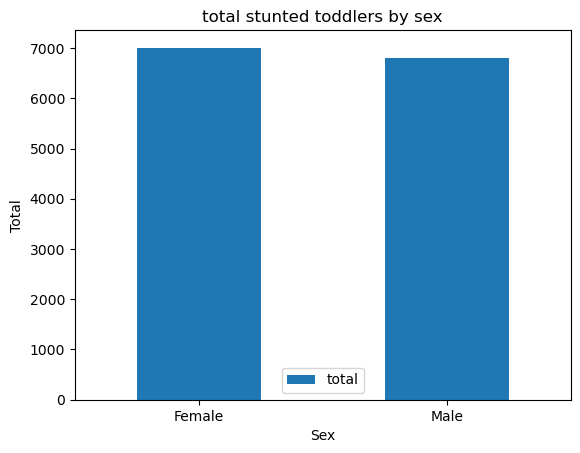

In [213]:
ax = df_stunted_gender.plot(kind='bar',title='total stunted toddlers by sex')
ax.set_xlabel('Sex')
ax.set_ylabel('Total')
plt.xticks([0,1],['Female','Male'])
ax.set_xticklabels(['Female','Male'],rotation=0)
plt.show()

### how many people based on calorie status ?

In [214]:
df_status_total = df['status'].groupby(df['status']).count().sort_values(ascending=False)

In [215]:
df_status_total

status
normal              67755
severely stunted    19869
tall                19560
stunted             13815
Name: status, dtype: int64

In [216]:
ax = df_status_total.plot(kind='barh',title='total distribution of nutritional status')
ax.set_ylabel('total')
plt.gca().invert_yaxis()
plt.show()

### what is the average height for calorie status ?

In [217]:
df_mean_height = df.groupby('status')['height(cm)'].mean()
df_mean_height=df_mean_height.sort_values(ascending=False)

In [218]:
df_mean_height

status
tall                94.912898
normal              92.702689
stunted             82.208722
severely stunted    73.176224
Name: height(cm), dtype: float64

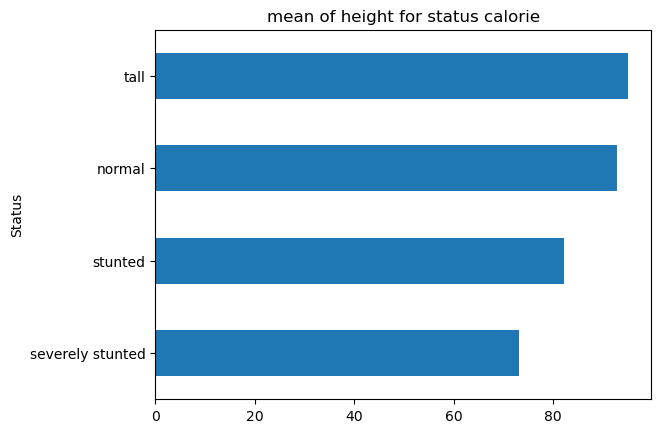

In [219]:
ax = df_mean_height.plot(kind='barh',title='mean of height for status calorie')
ax.set_ylabel('Status')
plt.gca().invert_yaxis()
plt.show()

## Data Preprocessing

* Turn gender into binary/numeric
* One Hot Encode status data column
* Normalize height data column

In [220]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.base import BaseEstimator , TransformerMixin
from sklearn.pipeline import Pipeline

In [221]:
#binary transformer for gender
class BinaryEncoder(BaseEstimator,TransformerMixin) : 
    def fit(self,X,y=None) : 
        return self
    def transform(self,X) : 
        binary_gender={'male':'0','female':'1'}
        X['gender'] = [binary_gender[i] for i in X['gender']]
        
        return X

#encoder for categorical data
class Encoder(BaseEstimator,TransformerMixin) : 
    def fit(self,X,y=None) : 
        return self 
    
    def transform(self,X) : 
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['status']]).toarray()
        status = ['stunted','tall','normal','severely stunted']
        
        for i in range(len(matrix.T)) : 
            X[status[i]] = matrix.T[i]
        
        X = X.drop(['status'],axis=1)
        
        return X

#normalization transfomer 
class Normalize(BaseEstimator,TransformerMixin) : 
    def fit(self,X,y=None) :
        return self 
    def transform(self,X) : 
        scaler_minmax = MinMaxScaler()
        
        normalized = scaler_minmax.fit_transform(X[['height(cm)']])
        X['height(cm)'] = normalized
        
        return X

In [222]:
binary = BinaryEncoder()
enc = Encoder()
norm = Normalize()

#manually transform with transformer class
#norm.fit_transform(enc.fit_transform(binary.fit_transform(df2)))


In [223]:
#build pipeline
pipe = Pipeline([
    ('binary',BinaryEncoder()),
    ('enc',Encoder()),
    ('norm',Normalize())
])
pipe

Pipeline(steps=[('binary', BinaryEncoder()), ('enc', Encoder()),
                ('norm', Normalize())])

In [224]:
df = pipe.fit_transform(df)